# Annealing schedules
#### Liza Darwesh 500793232

In [1]:
import neal
import datetime
import pandas as pd
import pandas_datareader.data as web
from dwave.system.samplers import DWaveSampler

sampler = neal.SimulatedAnnealingSampler()

In [5]:
def covariance(a,b):
    return a.cov(b)

def hi(name, price, returns, cov):

    # mean expected return
    E = np.mean(returns)

    # hi = -(1/2)((1/3)*cov(Ri,Ri) + (1/3)Ai^2 - (1/3)E(Ri) - 2B(1/3)*Ai)
    h_term = -0.5*((1/3)*cov + (1/3)* (Ai ** 2) - (1/3)* E - 2*B*(1/3)*Ai)
    h[name] = h_term

def Ji(name_i, name_j, cov):
    # Ji,j = -(1/4)((1/3)*cov(Ri,Rj) + (1/3)AiAj)
    coupler = -(0.25)*((1/3)*cov + ((1/3)*Ai*Aj))
    J[(name_i, name_j)] = coupler
    
def price_assets(a):
    all_data = {asset : web.get_data_yahoo(asset,start,end)
          for asset in a} 
    price = pd.DataFrame({asset : data['Adj Close']
                    for asset , data in all_data.items()})
    return price

def returns_assets(a):
    price_all_assets = price_assets(a)
    returns_unclean = price_all_assets.pct_change()
    returns_clean = returns_unclean.dropna()
    return returns_clean


In [6]:
# Money that can be invested
Ai = 50
Aj = 50
# Total budget
B = 200

#Dictorionary J and h terms
J = {}
h = {}

# Date of assets
start = datetime.datetime(2018,1,3)       
end = datetime.datetime(2021,1,1)

# Assets to work with
assets_dict = {'apple':'AAPL','ibm':'IBM','microsoft':'MSFT','google':'GOOGL'}

assets = []
asset_names = []
cov_assets = {}
cov_assets_coupled = {}

In [7]:
for key, value in assets_dict.items():
    asset_names.append(key)
    assets.append(value)

price = price_assets(assets)
returns = returns_assets(assets) 

# Covariance of the assets with themselves, 4 items
for i in assets:
    cov = covariance(returns[i], returns[i])
    cov_assets[i] = cov
    
# Covariance of the assets with each other, 6 items
for i in range(len(assets)):
    for j in range(i + 1, len(assets)):
        if j < len(assets):
            cov = covariance(returns[assets[i]], returns[assets[j]])
        else:
            j = 0
            cov = covariance(returns[assets[i]], returns[assets[j]])
        cov_assets_coupled[assets[i],assets[j]] = cov
        
for i in range(len(assets)):
    hi(asset_names[i], price[assets[i]], returns[assets[i]], cov_assets[assets[i]])

for key1, key2 in cov_assets_coupled:
    Ji(key1, key2, cov_assets_coupled[key1,key2])

In [8]:
#-------------------------------------------------------------------------
#                       Test bias and coupler
#-------------------------------------------------------------------------

# h = {0: 1.0, 1: -1.0, 2: -1.0, 3: 1.0, 4: 1.0, 5: -1.0, 6: 0.0, 7: 1.0,
#      8: 1.0, 9: -1.0, 10: -1.0, 11: 1.0, 12: 1.0, 13: 0.0, 14: -1.0, 15: 1.0}
# J = {(9, 13): -1, (2, 6): -1, (8, 13): -1, (9, 14): -1, (9, 15): -1,
#      (10, 13): -1, (5, 13): -1, (10, 12): -1, (1, 5): -1, (10, 14): -1,
#      (0, 5): -1, (1, 6): -1, (3, 6): -1, (1, 7): -1, (11, 14): -1,
#      (2, 5): -1, (2, 4): -1, (6, 14): -1}

In [9]:
runs=1000
import neal
sampler = neal.SimulatedAnnealingSampler()
results = sampler.sample_ising(h, J, 
    num_reads=runs,
    answer_mode='raw',
    label='Notebook - Anneal Schedule',
    annealing_time=100)

print("QPU time used:", results.info, "microseconds.")
print(results)

QPU time used: {'beta_range': [0.00023765044424928883, 0.02210481500151368], 'beta_schedule_type': 'geometric'} microseconds.
    AAPL GOOGL IBM MSFT apple google ibm microsoft        energy num_oc.
0     -1    -1  -1   -1    -1     -1  -1        -1 -12916.667228       1
1     +1    +1  +1   +1    -1     -1  -1        -1 -12916.667228       1
2     -1    -1  -1   -1    -1     -1  -1        -1 -12916.667228       1
3     +1    +1  +1   +1    -1     -1  -1        -1 -12916.667228       1
4     -1    -1  -1   -1    -1     -1  -1        -1 -12916.667228       1
5     +1    +1  +1   +1    -1     -1  -1        -1 -12916.667228       1
6     -1    -1  -1   -1    -1     -1  -1        -1 -12916.667228       1
7     +1    +1  +1   +1    -1     -1  -1        -1 -12916.667228       1
8     -1    -1  -1   -1    -1     -1  -1        -1 -12916.667228       1
9     +1    +1  +1   +1    -1     -1  -1        -1 -12916.667228       1
10    +1    +1  +1   +1    -1     -1  -1        -1 -12916.667228       

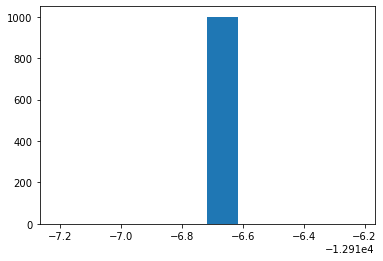

In [10]:
plt.hist(results.record.energy,rwidth=1,align='left')
plt.show()

In [11]:
_, counts = np.unique(results.record.energy.reshape(1000,1), axis=0, return_counts=True)
print("Ground state probability: ", counts[0]/runs)

Ground state probability:  1.0


In [12]:
import json
with open("files/saved_pause_results.json", "r") as read_file:
    saved_pause_success_prob = pd.read_json(json.load(read_file))

In [14]:
#Update the standard anneal schedule parameters below: 

anneal_time = 10.0
pause_duration = 500.0      # Must be greater than 0
pause_start = 0.4        # Must be between 0 and 1

#----------------------------------------------------------------
#Leave the code below to run the problem and display the results.
#----------------------------------------------------------------
schedule=[[0.0,0.0],[pause_start*anneal_time,pause_start],[pause_start*anneal_time+pause_duration, pause_start],[anneal_time+pause_duration, 1.0]]
runs=900
results = sampler.sample_ising(h, J,
                anneal_schedule=schedule,
                num_reads=runs, 
                answer_mode='raw',
                label='Notebook - Anneal Schedule',                        
                num_spin_reversal_transforms=1)
success = np.count_nonzero(results.record.energy == -20.0)/runs
print("Success probability: ",success)

p.scatter([pause_start],[success], color="red")
show(p)
print(results)

Success probability:  0.0


    AAPL GOOGL IBM MSFT apple google ibm microsoft        energy num_oc.
0     +1    +1  +1   +1    -1     -1  -1        -1 -12916.667228       1
1     +1    +1  +1   +1    -1     -1  -1        -1 -12916.667228       1
2     +1    +1  +1   +1    -1     -1  -1        -1 -12916.667228       1
3     -1    -1  -1   -1    -1     -1  -1        -1 -12916.667228       1
4     +1    +1  +1   +1    -1     -1  -1        -1 -12916.667228       1
5     -1    -1  -1   -1    -1     -1  -1        -1 -12916.667228       1
6     -1    -1  -1   -1    -1     -1  -1        -1 -12916.667228       1
7     +1    +1  +1   +1    -1     -1  -1        -1 -12916.667228       1
8     -1    -1  -1   -1    -1     -1  -1        -1 -12916.667228       1
9     -1    -1  -1   -1    -1     -1  -1        -1 -12916.667228       1
10    -1    -1  -1   -1    -1     -1  -1        -1 -12916.667228       1
11    -1    -1  -1   -1    -1     -1  -1        -1 -12916.667228       1
12    -1    -1  -1   -1    -1     -1  -1        -1 

In [15]:
with open("files/saved_quench_results.json", "r") as read_file:
    saved_quench_success_prob = pd.read_json(json.load(read_file))

In [18]:
#Update the standard anneal schedule parameters below 

anneal_time = 50.0
quench_slope = 1.0      # Must be greater than 0
quench_start = 0.2      # Must be between 0 and 1

#----------------------------------------------------------------
#Leave the code below to run the problem and display the results.
#----------------------------------------------------------------
schedule=[[0.0,0.0],[quench_start*anneal_time,quench_start],[(1-quench_start+quench_slope*quench_start*anneal_time)/quench_slope, 1.0]]
runs=900
results = sampler.sample_ising(h, J,
                anneal_schedule=schedule,
                num_reads=runs, 
                answer_mode='raw',
                label='Notebook - Anneal Schedule',
                num_spin_reversal_transforms=1)
success = np.count_nonzero(results.record.energy == -20.0)/runs
print("Success probability: ",success)

p.scatter([quench_start],[success], color="red")
show(p)
print(results)

Success probability:  0.0


    AAPL GOOGL IBM MSFT apple google ibm microsoft        energy num_oc.
0     -1    -1  -1   -1    -1     -1  -1        -1 -12916.667228       1
1     -1    -1  -1   -1    -1     -1  -1        -1 -12916.667228       1
2     -1    -1  -1   -1    -1     -1  -1        -1 -12916.667228       1
3     -1    -1  -1   -1    -1     -1  -1        -1 -12916.667228       1
4     -1    -1  -1   -1    -1     -1  -1        -1 -12916.667228       1
5     +1    +1  +1   +1    -1     -1  -1        -1 -12916.667228       1
6     -1    -1  -1   -1    -1     -1  -1        -1 -12916.667228       1
7     -1    -1  -1   -1    -1     -1  -1        -1 -12916.667228       1
8     -1    -1  -1   -1    -1     -1  -1        -1 -12916.667228       1
9     -1    -1  -1   -1    -1     -1  -1        -1 -12916.667228       1
10    -1    -1  -1   -1    -1     -1  -1        -1 -12916.667228       1
11    +1    +1  +1   +1    -1     -1  -1        -1 -12916.667228       1
12    +1    +1  +1   +1    -1     -1  -1        -1 